In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import math

import numpy as np
import datetime
from IPython.display import display
import pandas as pd

from garmindb import GarminConnectConfigManager
from garmindb.garmindb import GarminSummaryDb, DaysSummary, MonitoringDb, MonitoringHeartRate, Sleep, GarminDb
from garmindb.summarydb import DaysSummary, SummaryDb

from jupyter_funcs import format_number
from graphs import Graph

In [2]:
def minsFromTime(t):
    return float(t.hour * 3600 + t.minute * 60 + t.second) / 60.0

In [3]:
# start date
start_ts = datetime.datetime.combine(datetime.date(year=2024, month=10, day=1), datetime.datetime.min.time())
# end date (today)
end_ts = datetime.datetime.combine(datetime.date.today(), datetime.datetime.max.time())

gc_config = GarminConnectConfigManager()
db_params = gc_config.get_db_params()

garmin_db = GarminDb(db_params)
sum_db = SummaryDb(db_params, False)
data = DaysSummary.get_for_period(sum_db, start_ts, end_ts, DaysSummary)
sleep = Sleep.get_for_period(garmin_db, start_ts, end_ts)

time = [entry.day for entry in data]

In [4]:
# start date
start_ts = datetime.datetime.combine(datetime.date(year=2024, month=10, day=1), datetime.datetime.min.time())
# end date (today)
end_ts = datetime.datetime.combine(datetime.date(year=2024, month=11, day=1), datetime.datetime.min.time())

gc_config = GarminConnectConfigManager()
db_params = gc_config.get_db_params()

garmin_db = GarminDb(db_params)
sum_db = SummaryDb(db_params, False)
data = DaysSummary.get_for_period(sum_db, start_ts, end_ts, DaysSummary)
sleep = Sleep.get_for_period(garmin_db, start_ts, end_ts)

time = [entry.day for entry in data]

In [5]:
stress_avg = [entry.stress_avg for entry in data]
hr_min = [entry.hr_min for entry in data]
rhr_avg = [entry.rhr_avg for entry in data]
hr_max = [entry.hr_max for entry in data]
bb_max = [entry.bb_max for entry in data]
bb_min = [entry.bb_min for entry in data]
rem_sleep_max = [minsFromTime(entry.rem_sleep_avg) for entry in data]
sleep_avg = [minsFromTime(entry.sleep_avg) / 60 for entry in data]
deep_sleep = [minsFromTime(sleep_event.deep_sleep) for sleep_event in sleep]
dm_df = pd.DataFrame([time, stress_avg, hr_min, rhr_avg, hr_max, bb_max, bb_min, rem_sleep_max,deep_sleep, sleep_avg]).T
dm_df.columns = ["Date", "stress_avg" ,"hr_min", "rhr_avg", "hr_max","bb_max", "bb_min", "rem_sleep_max", "deep_sleep", "sleep_avg"]
# remove the last record 'cause it's noisy sometimes
dm_df.drop(dm_df.tail(1).index,inplace=True) 
dm_df



,Date,stress_avg,hr_min,rhr_avg,hr_max,bb_max,bb_min,rem_sleep_max,deep_sleep,sleep_avg


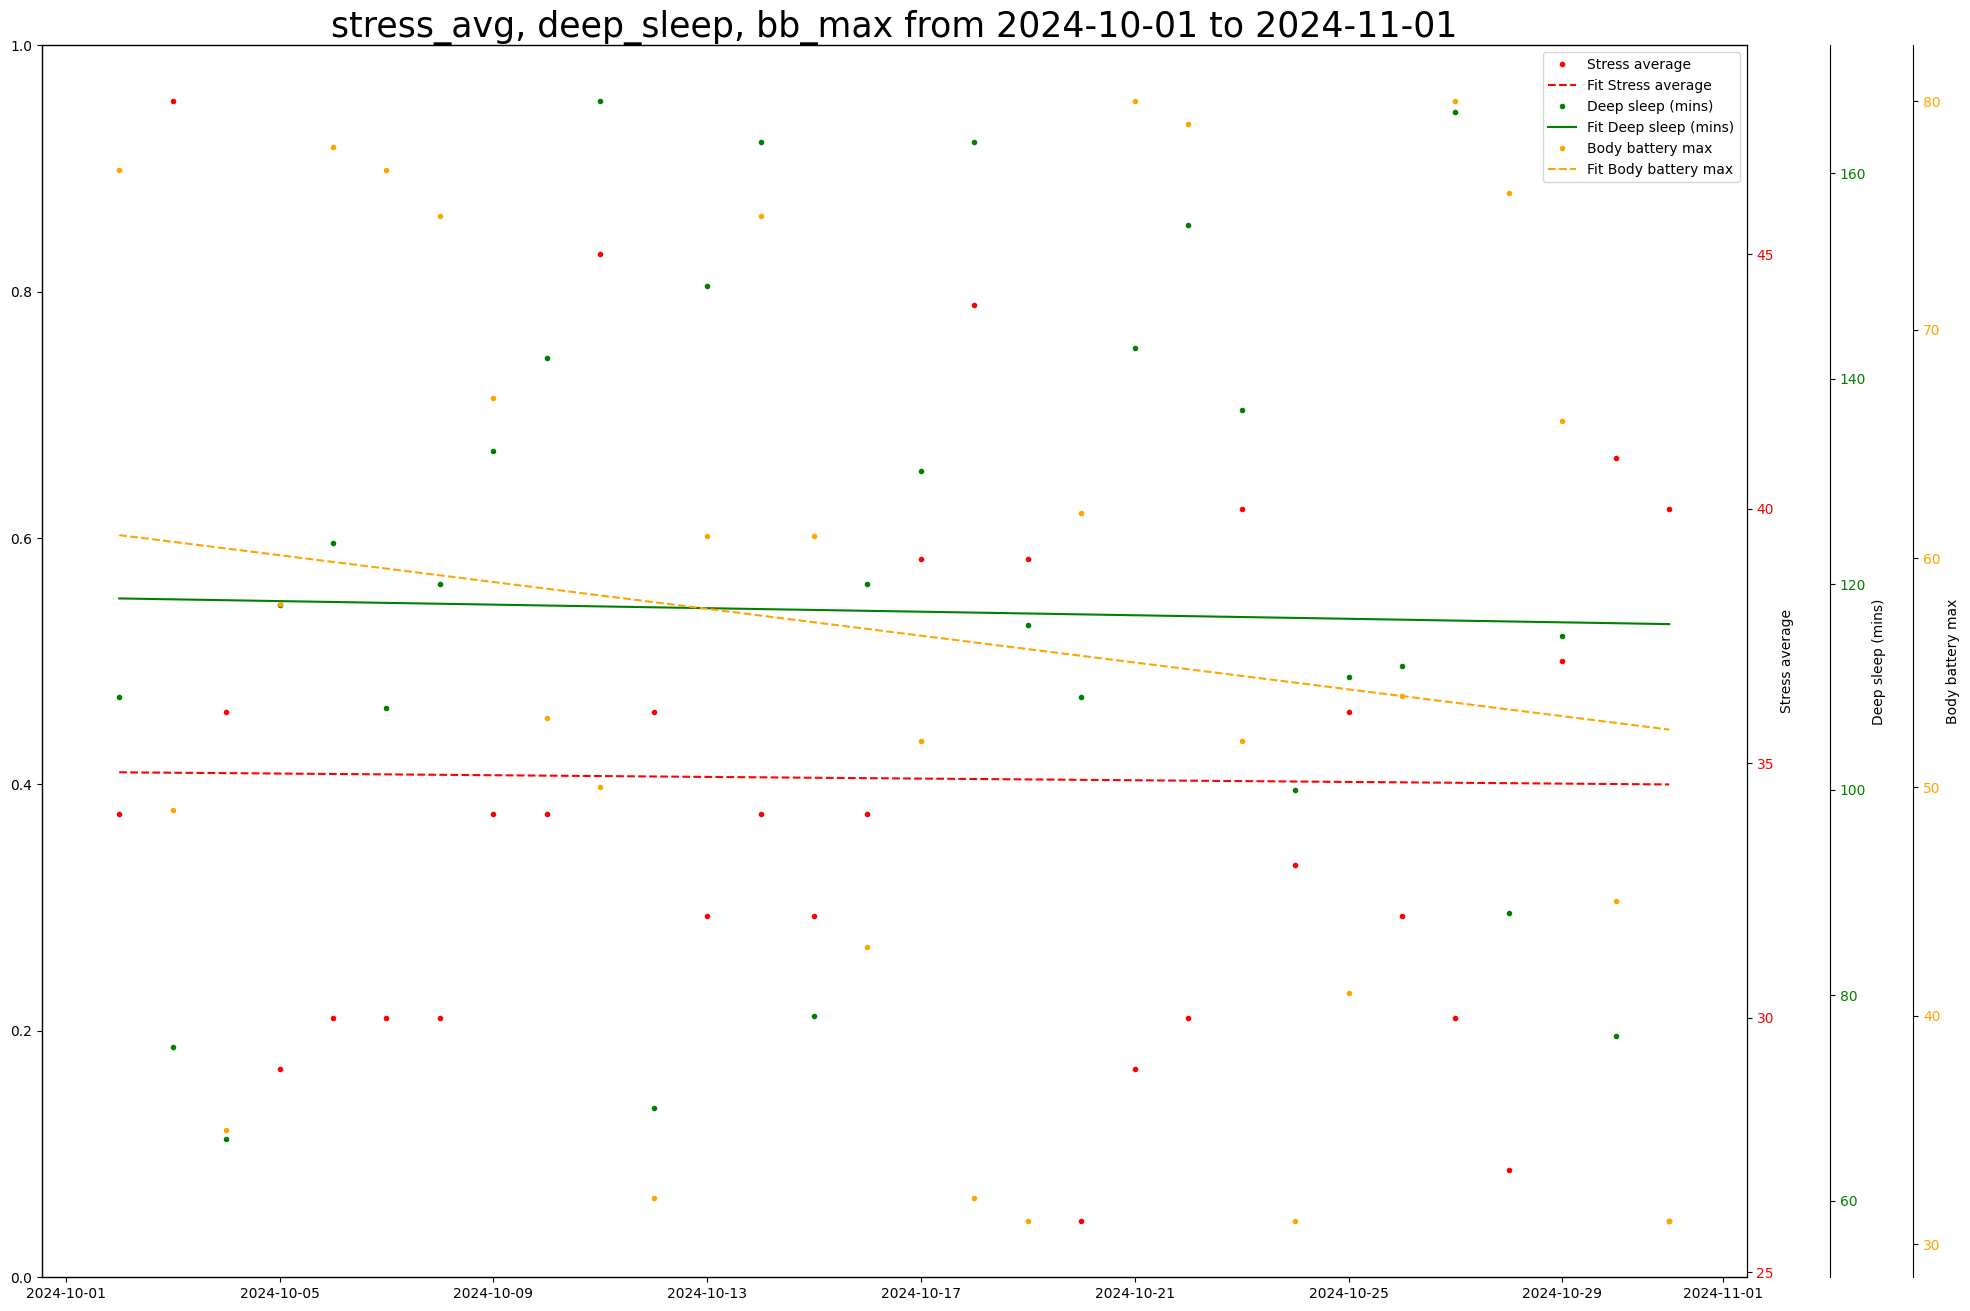

,,min,max
0,Fit Stress average,34,34
1,Fit Deep sleep (mins),116,118
2,Fit Body battery max,52,61


In [13]:


columns = { "stress_avg" : 
                   {
                       "label": "Stress average",
                       "trend_marker": "--",
                       "color": "red"

                   }, 
            "bb_max": 
                   {
                       "label": "Body battery max",
                       "trend_marker": "--",
                       "color": "orange"
                   },
           
            "sleep_avg": 
                   {
                       "label": "Sleep time (hrs)",
                       "trend_marker": "-.",
                       "color": "blue"
                  },
            "rem_sleep_max": 
                   {
                       "label": "Rem Sleep time (mins)",
                       "trend_marker": "-",
                       "color": "purple"
                   },
           
            "deep_sleep": 
                   {
                       "label": "Deep sleep (mins)",
                       "trend_marker": "-",
                       "color": "green"
                   }
          }

# these are the data columns to plot
show_cols = {"deep_sleep", "stress_avg", "bb_max"}

fig, host = plt.subplots(figsize=(22,16))

plots = []
fit_summary = []
step = 0

for col in show_cols:
    label=columns[col]["label"]
   
    ax2 = host.twinx()
    ax2.set_ylabel(label)
    ax2.tick_params(axis='y', labelcolor=columns[col]["color"])

    # data
    plot, = ax2.plot(dm_df.Date, dm_df[col], 'o', ms=3.0, color=columns[col]["color"], label=label)
    plots.append(plot)
    
    # trend
    fitlabel = 'Fit {}'.format(label)
    x_dates = dates.date2num(dm_df.Date)
    trend = np.polyfit(x_dates, dm_df[col].astype(float) , 1)
    fit = np.poly1d(trend)
    x_fit = np.linspace(x_dates.min(), x_dates.max())
    fit, = ax2.plot(dates.num2date(x_fit), fit(x_fit), linestyle=columns[col]["trend_marker"], color=columns[col]["color"],label=fitlabel)
    plots.append(fit)
    
    ax2.spines['right'].set_position(('outward', step))
    
    step = step + 60

    fit_data = fit.get_ydata()
    
    fit_summary.append({"": fitlabel, "min": math.floor(fit_data.min()), "max":math.floor(fit_data.max())})
    
host.legend(handles=plots, loc='best')

col_label = ""
for col in show_cols:
    if len(col_label):
        col_label += ", "
    col_label += f"{col}"

title = f"{col_label} from {start_ts.date()} to {end_ts.date()}"

plt.title(label=title, fontsize=25)

plt.show()
pd.DataFrame(fit_summary)